## Variable Selection for Classifier that Predicts Death of Heart Failure Patients


## Introduction

Heart failure occurs when the damaged or weakened heart muscle is unbale to pump blood efficiently to meet body’s needs. Multiple researches found that the risk factors of heart failure include but not limited to high blood pressure, diabetes, and smoking (Inamdar & Inamdar, 2016). This leads to the question of which predictor(s) are useful in predicting a heart failure patient’s survival after some period of time given their information. To answer this question, we will build models to analyze the “Heart Failure Prediction” dataset that was collected by Ahmad et al. in 2017. There are 11 predictors in the dataset but only 10 will be used:

* Age (years)
* Anaemia status (binary)
* Blood creatinine phosphokinase level (mcg/L) 
* Diabetes status (binary)
* Ejection fraction (percentage of blood leaving the heart at each contraction)
* High blood pressure status (binary)
* Platelets level in blood (kiloplatelets/mL)
* Level of serum creatinine in blood (mg/dL)
* Level of serum sodium in blood (mEq/L)
* Sex (binary, 0 for female and 1 for male)
* Smoking status (binary)

## Methods
A k-nearest-neighbor classifier will be made to answer the proposed question. Most importantly, the variable time (follow-up period) will be excluded because it is different for each patient, and there were no details regarding the kind of follow-ups, which makes it harder to understand the role of this predictor. We acknowledge that this is a simplification, and that our model only predicts whether a patient will die or not after some finite time, but the amount of time does not matter. For variable selection, best subset selection will be attempted first, but if it ends up being non-feasible due to high volumes of computations, we would use forward selection which is less computationally costly. The selected classifier will then be trained with the best K-value found from cross-validation.

During the process of building our model, visualising the result of each step would be crucial for analysing the result. We can achieve that by generating different charts using the ggplot function. For example, when choosing a k-value with the highest accuracy, we would apply cross-validation, and visualize the result (k-value verses accuracy) by geom_line() function.

## Preliminary Exploratory Data Analysis

In [1]:
install.packages("themis")

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# import libraries for R functions
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
library(themis)

In [4]:
# load data from the web
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
original_data <- read_csv(url)
# original_data

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
# turn binary variables into factors

original_data <- original_data |>
    mutate(anaemia = as_factor(anaemia),
          diabetes = as_factor(diabetes),
          high_blood_pressure = as_factor(high_blood_pressure),
          platelets_num_per_mL = platelets/1000,
          sex = as_factor(sex),
          smoking = as_factor(smoking),
          DEATH_EVENT = as_factor(DEATH_EVENT))
original_data

# man is 1 in sex, woman is 0 since the paper said 194 men and 105 women, filtering for sex == 1 gives as 194 rows

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,platelets_num_per_mL
<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1,265.000
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1,263.358
65,0,146,0,20,0,162000,1.3,129,1,1,7,1,162.000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,0,2060,1,60,0,742000,0.8,138,0,0,278,0,742
45,0,2413,0,38,0,140000,1.4,140,1,1,280,0,140
50,0,196,0,45,0,395000,1.6,136,1,1,285,0,395


In [6]:
# split the data into training and testing sets

set.seed(1625)

# split the data for 75% training and 25% testing, roughly same ratio of survived to dead in both sets as the original
data_split <- initial_split(original_data, prop = 0.75, strata = DEATH_EVENT)
training_data <- training(data_split)
testing_data <- testing(data_split)


In [7]:
# finding summary data of the training set

# mean of numerical predictors among survived or dead patients

numerical_preds <- c("Age (years)", "Creatinine phosphokinase (mcg/L)", "Ejection fraction (%)", "Platelet level (platelet/mL)", 
                     "Serum creatinine (mg/dL)", "Serum sodium (mEq/L)", "Follow-up period length (days)")

# make a function to find the mean of the numerical predictors among the survived patients
find_mean_survived <- function(dat) {
    
    result_list <- c()
    
    num_pred_only_data <- dat |> select(age, creatinine_phosphokinase, ejection_fraction, platelets_num_per_mL, 
                                        serum_creatinine, serum_sodium, time, DEATH_EVENT)
    
    for (i in 1:7) {
        
        curr_column <- num_pred_only_data[,i]
        death_event_column <- num_pred_only_data[,length(num_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        colnames(grouped_columns) <- c("Predictor", "Response")
        as_factor(grouped_columns$Response)
        
        result_list[i] <- mean(filter(grouped_columns, Response == 0)$Predictor, na.rm = TRUE)
        #mean_summary_dead[i] <- mean(filter(grouped_columns, Response == 1)$Predictor, na.rm = TRUE)
        
    }
    
    result_list
        
}


# make a function to find the mean of the numerical predictors among the dead patients
find_mean_dead <- function(dat) {
    
    result_list <- c()
    
    num_pred_only_data <- dat |> select(age, creatinine_phosphokinase, ejection_fraction, platelets_num_per_mL, 
                                        serum_creatinine, serum_sodium, time, DEATH_EVENT)
    
    for (i in 1:7) {
        
        curr_column <- num_pred_only_data[,i]
        death_event_column <- num_pred_only_data[,length(num_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        colnames(grouped_columns) <- c("Predictor", "Response")
        as_factor(grouped_columns$Response)
        
        result_list[i] <- mean(filter(grouped_columns, Response == 1)$Predictor, na.rm = TRUE)
        
    }
    
    result_list
        
}

# find the mean for each numerical predictors among the survived patients
mean_summary_survived <- find_mean_survived(training_data)

# find the mean for each numerical predictors among the dead patients
mean_summary_dead <- find_mean_dead(training_data)



# make a function to find the percentage of survived patients for each category of categorial variables

categorical_preds <- c("Anaemia", "No anameia", "Diabetes", "No diabetes", "High blood pressure", 
                       "No high blood pressure", "Male", "Female", "Smoker", "Non-smoker")


find_ratio_yes <- function(dat) {
    
    result_list <- c()
    
    categ_pred_only_data <- dat |> 
        select(anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)
    
    for (i in 1:5) {
        
        curr_column <- categ_pred_only_data[,i]
        death_event_column <- categ_pred_only_data[,length(categ_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        
        colnames(grouped_columns) <- c("Predictor", "Response")
        
        as_factor(grouped_columns$Predictor)
        as_factor(grouped_columns$Response)
        
        
        filtered_response_yes <- filter(grouped_columns, Predictor == 1)[,2]

        number_survived_yes <- nrow(filter(filtered_response_yes, Response == 0))
        
        result_list[i] <- number_survived_yes/nrow(filtered_response_yes)*100
        
    }
    
    result_list
        
}



find_ratio_no <- function(dat) {
    
    result_list <- c()
    
    categ_pred_only_data <- dat |> 
        select(anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)
    
    for (i in 1:5) {
        
        curr_column <- categ_pred_only_data[,i]
        death_event_column <- categ_pred_only_data[,length(categ_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        
        colnames(grouped_columns) <- c("Predictor", "Response")
        
        as_factor(grouped_columns$Predictor)
        as_factor(grouped_columns$Response)
        
        
        filtered_response_no <- filter(grouped_columns, Predictor == 0)[,2]

        number_survived_no <- nrow(filter(filtered_response_no, Response == 0))
        
        result_list[i] <- number_survived_no/nrow(filtered_response_no)*100
        
    }
    
    result_list
        
}

ratio_summary_yes <- find_ratio_yes(training_data)

ratio_summary_no <- find_ratio_no(training_data)

ratio_summary <- c(ratio_summary_yes[1], ratio_summary_no[1],
                   ratio_summary_yes[2], ratio_summary_no[2],
                   ratio_summary_yes[3], ratio_summary_no[3],
                   ratio_summary_yes[4], ratio_summary_no[4],
                   ratio_summary_yes[5], ratio_summary_no[5])


##### Table 1. Mean of numerical predictors across survived and dead patients

In [8]:
# Create summary table 1
options(repr.matrix.max.rows = 10)
table_1 <- tibble(numerical_preds, round(mean_summary_survived, 4), round(mean_summary_dead, 4))
colnames(table_1) <- c("Predictor", "Mean predictor value among survived patients", "Mean predictor value among dead patients")
head(table_1, n = 10)

Predictor,Mean predictor value among survived patients,Mean predictor value among dead patients
<chr>,<dbl>,<dbl>
Age (years),59.2675,65.5232
Creatinine phosphokinase (mcg/L),521.2368,612.4583
Ejection fraction (%),40.4408,33.5694
Platelet level (platelet/mL),267.9566,255.1737
Serum creatinine (mg/dL),1.2170,1.8928
Serum sodium (mEq/L),136.8684,135.1389
Follow-up period length (days),164.6447,74.0139


##### Table 2. Percentage of survived patients for each category of binary variables

In [9]:
# Create summary table 2
options(repr.matrix.max.rows = 10)
table_2 <- tibble(categorical_preds, round(ratio_summary, 4))
colnames(table_2) <- c("Predictor", "Percentage of survived patients")
head(table_2, 10)

Predictor,Percentage of survived patients
<chr>,<dbl>
Anaemia,62.3656
No anameia,71.7557
Diabetes,68.4783
No diabetes,67.4242
High blood pressure,61.3333
No high blood pressure,71.1409
Male,69.9301
Female,64.1975
Smoker,70.8333


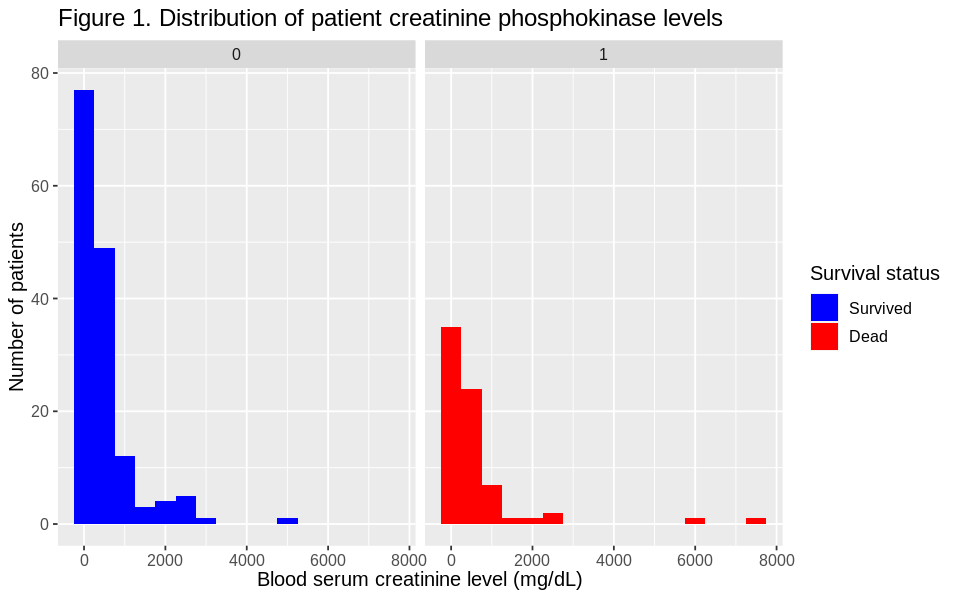

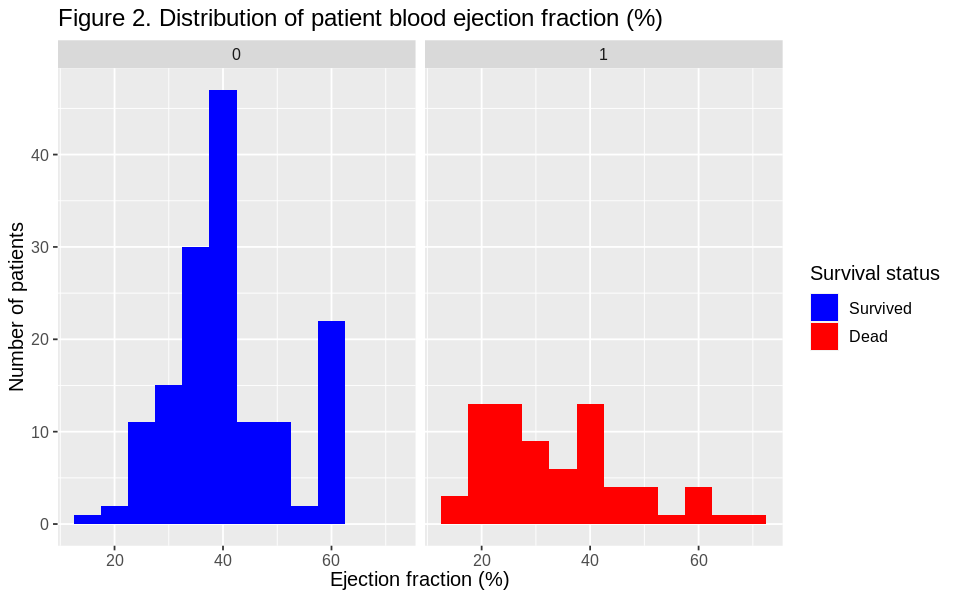

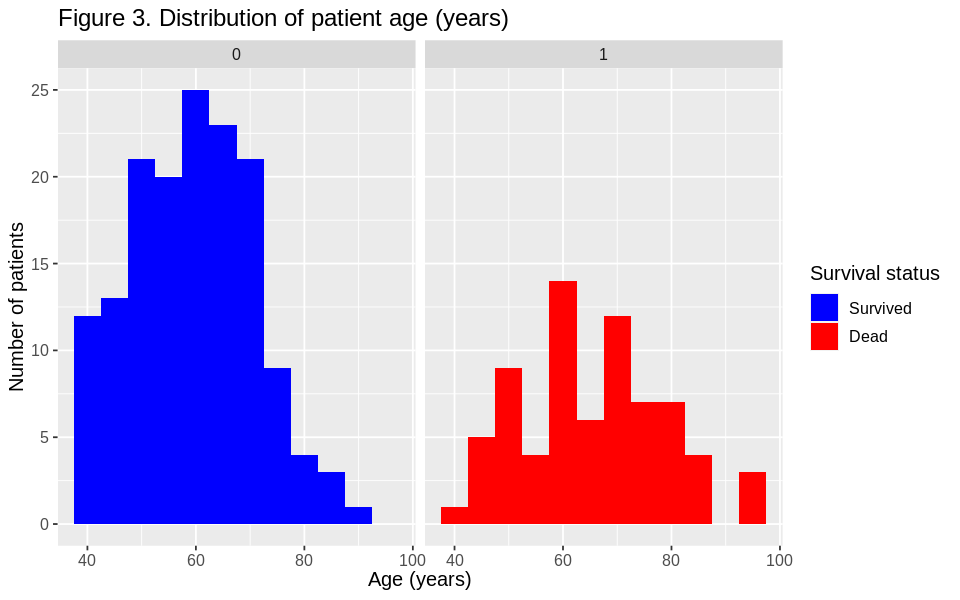

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



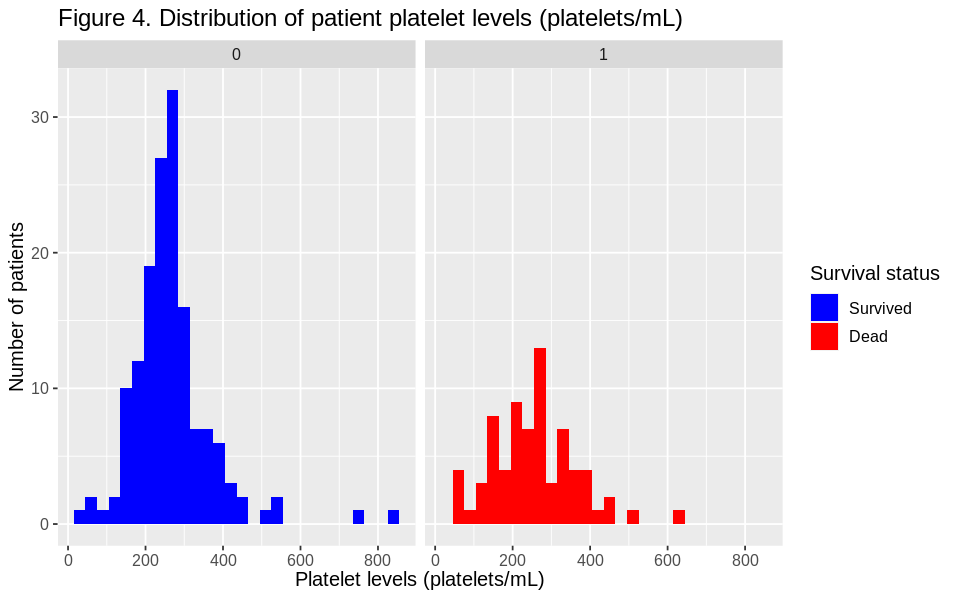

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



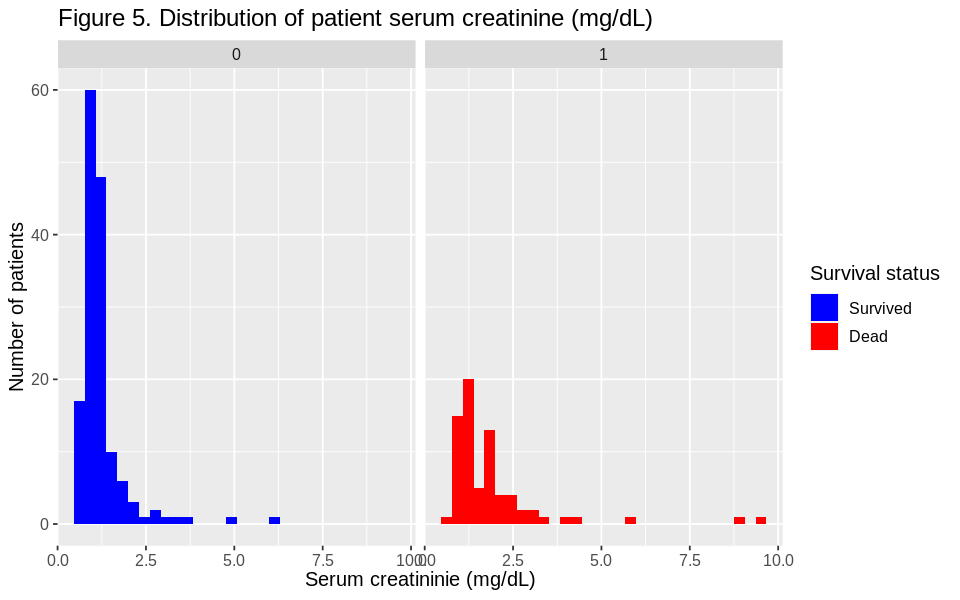

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



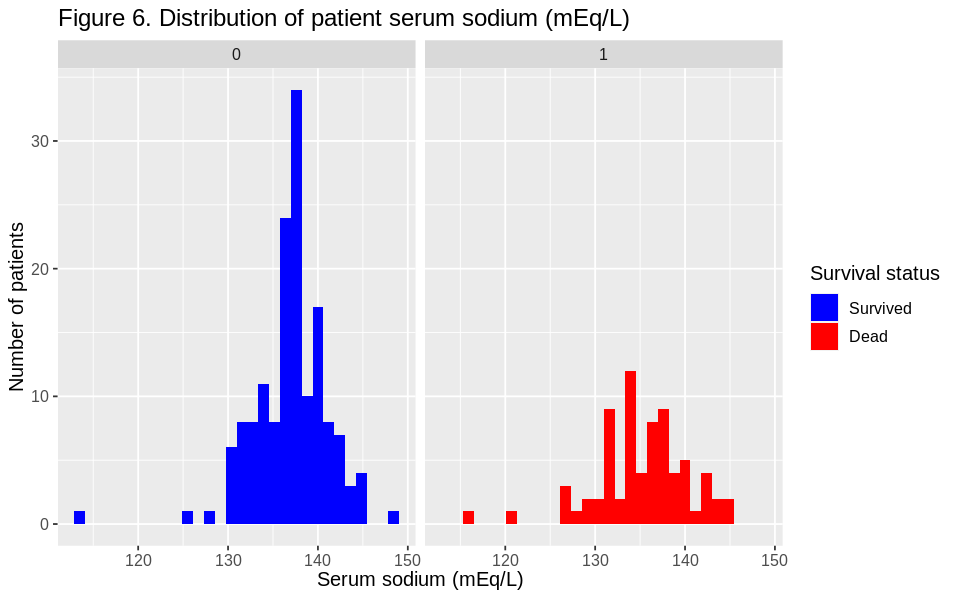

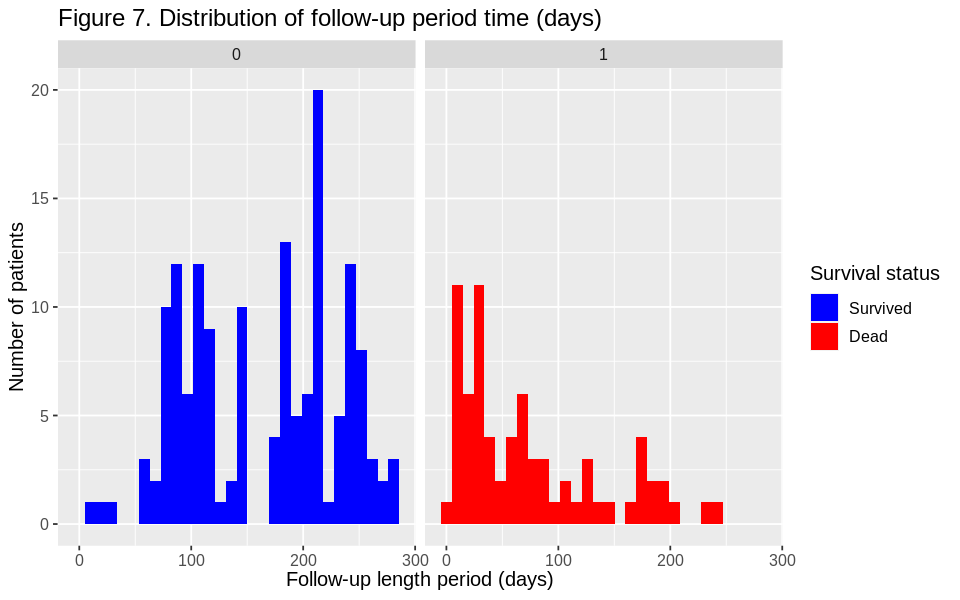

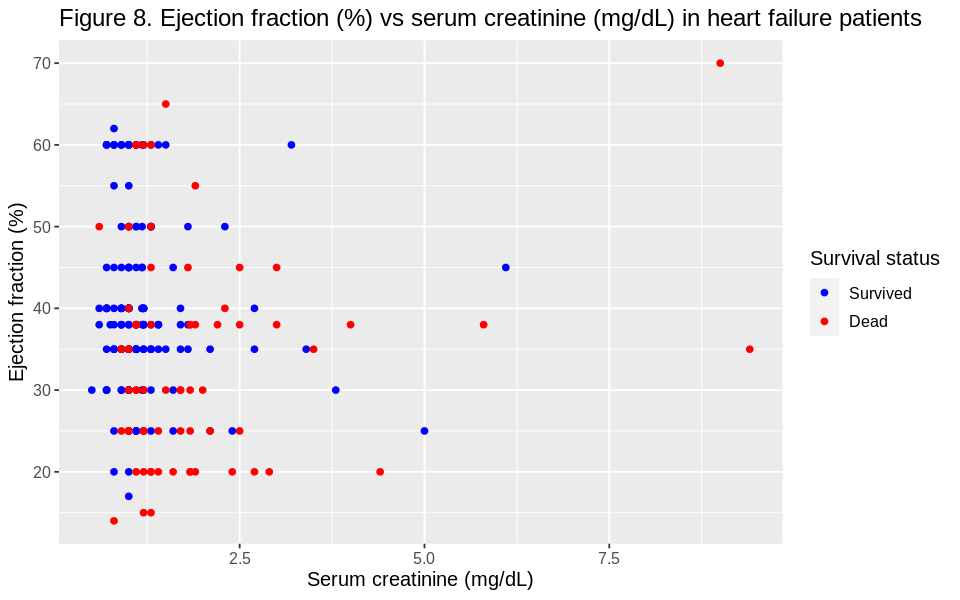

In [10]:
# Plots
options(repr.plot.height = 5, repr.plot.width = 8)

plot1 <- training_data |>
    ggplot(aes(x = creatinine_phosphokinase, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 500) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Blood serum creatinine level (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 1. Distribution of patient creatinine phosphokinase levels") + 
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot1

plot2 <- training_data |>
    ggplot(aes(x = ejection_fraction, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Ejection fraction (%)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 2. Distribution of patient blood ejection fraction (%)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot2

plot3 <- training_data |>
    ggplot(aes(x = age, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Age (years)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 3. Distribution of patient age (years)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot3

plot4 <- training_data |>
    ggplot(aes(x = platelets_num_per_mL, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 30) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Platelet levels (platelets/mL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 4. Distribution of patient platelet levels (platelets/mL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot4

plot5 <- training_data |>
    ggplot(aes(x = serum_creatinine, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum creatininie (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 5. Distribution of patient serum creatinine (mg/dL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot5

plot6 <- training_data |>
    ggplot(aes(x = serum_sodium, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum sodium (mEq/L)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 6. Distribution of patient serum sodium (mEq/L)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot6

plot7 <- training_data |>
    ggplot(aes(x = time, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Follow-up length period (days)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 7. Distribution of follow-up period time (days)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot7

plot8 <- training_data |>
    ggplot(aes(x = serum_creatinine, y = ejection_fraction, color = DEATH_EVENT)) +
    geom_point() +
    labs(x = "Serum creatinine (mg/dL)",
         y = "Ejection fraction (%)",
         color = "Survival status",
         title = "Figure 8. Ejection fraction (%) vs serum creatinine (mg/dL) in heart failure patients") +
    scale_color_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot8

### Rebalancing the Training Set ###

In [64]:
original_death <- training_data |>
    filter(DEATH_EVENT == 1)
nrow(original_death)

original_survived <- training_data |>
    filter(DEATH_EVENT == 0)
nrow(original_survived)

[1] 72

[1] 152

In [65]:
ups_recipe <- recipe(DEATH_EVENT ~ ., data = training_data) |>
  step_upsample(DEATH_EVENT, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         13

Training data contained 224 data points and no missing data.

Operations:

Up-sampling based on DEATH_EVENT [trained]

In [66]:
balanced_data <- ups_recipe |> bake(training_data)
balanced_data

age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,platelets_num_per_mL,DEATH_EVENT
<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
49,1,80,0,30,1,427000,1.0,138,0,0,12,427,0
53,0,63,1,60,0,368000,0.8,135,1,0,22,368,0
72,0,127,1,50,1,218000,1.0,134,1,0,33,218,0
70,1,75,0,35,0,223000,2.7,138,1,1,54,223,0
60,1,607,0,40,0,216000,0.6,138,1,1,54,216,0
55,0,109,0,35,0,254000,1.1,139,1,1,60,254,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
95,1,112,0,40,1,196000,1.00,138,0,0,24,196.000,1
45,0,582,0,20,1,126000,1.60,135,1,0,180,126.000,1


In [67]:
balanced_death <- balanced_data |>
    filter(DEATH_EVENT == 1)
nrow(balanced_death)

balanced_survived <- balanced_data |>
    filter(DEATH_EVENT == 0)
nrow(balanced_survived)

[1] 152

[1] 152

In [69]:
# find the mean for each numerical predictors among the survived patients
mean_summary_survived_balanced <- find_mean_survived(balanced_data)

# find the mean for each numerical predictors among the dead patients
mean_summary_dead_balanced <- find_mean_dead(balanced_data)

# find percentage of survived patients in each category of binary variables
ratio_summary_yes_balanced <- find_ratio_yes(balanced_data)

ratio_summary_no_balanced <- find_ratio_no(balanced_data)

ratio_summary_balanced <- c(ratio_summary_yes_balanced[1], ratio_summary_no_balanced[1],
                            ratio_summary_yes_balanced[2], ratio_summary_no_balanced[2],
                            ratio_summary_yes_balanced[3], ratio_summary_no_balanced[3],
                            ratio_summary_yes_balanced[4], ratio_summary_no_balanced[4],
                            ratio_summary_yes_balanced[5], ratio_summary_no_balanced[5])

##### Table 3. Mean of numerical predictors across survived and dead patients after rebalancing

In [72]:
# Create summary table 3
options(repr.matrix.max.rows = 10)
table_3 <- tibble(numerical_preds, round(mean_summary_survived_balanced, 4), round(mean_summary_dead_balanced, 4))
colnames(table_3) <- c("Predictor", "Mean predictor value among survived patients", "Mean predictor value among dead patients")
head(table_3, n = 10)

Predictor,Mean predictor value among survived patients,Mean predictor value among dead patients
<chr>,<dbl>,<dbl>
Age (years),59.2675,66.9232
Creatinine phosphokinase (mcg/L),521.2368,743.9079
Ejection fraction (%),40.4408,34.9605
Platelet level (platelet/mL),267.9566,250.9484
Serum creatinine (mg/dL),1.2170,1.7214
Serum sodium (mEq/L),136.8684,135.2961
Follow-up period length (days),164.6447,73.2171


##### Table 4. Percentage of survived patients for each category of binary variables after rebalancing

In [73]:
# Create summary table 4
options(repr.matrix.max.rows = 10)
table_4 <- tibble(categorical_preds, round(ratio_summary_balanced, 4))
colnames(table_4) <- c("Predictor", "Percentage of survived patients")
head(table_4, 10)

Predictor,Percentage of survived patients
<chr>,<dbl>
Anaemia,43.9394
No anameia,54.6512
Diabetes,53.3898
No diabetes,47.8495
High blood pressure,48.4211
No high blood pressure,50.7177
Male,50.2513
Female,49.5238
Smoker,56.6667


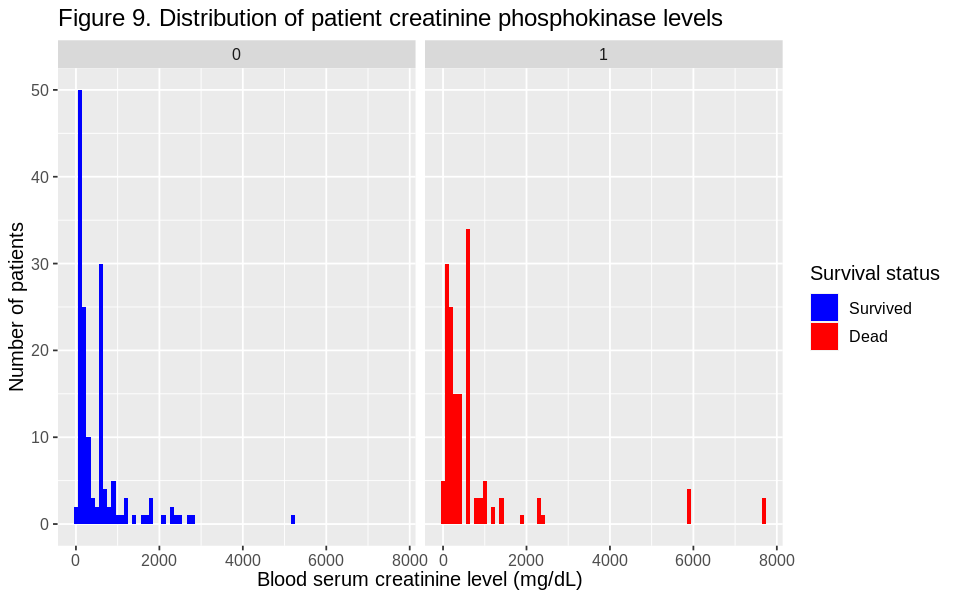

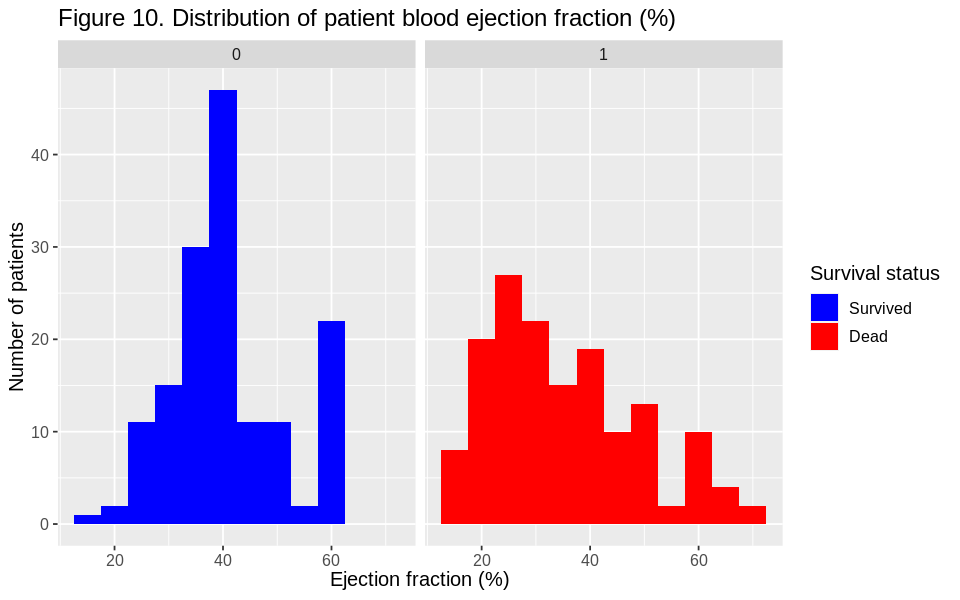

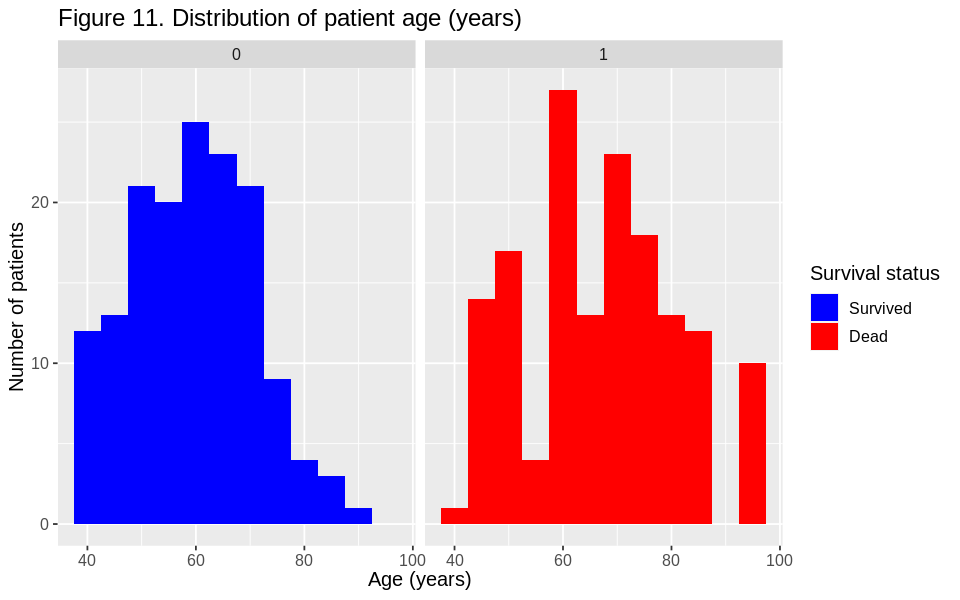

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



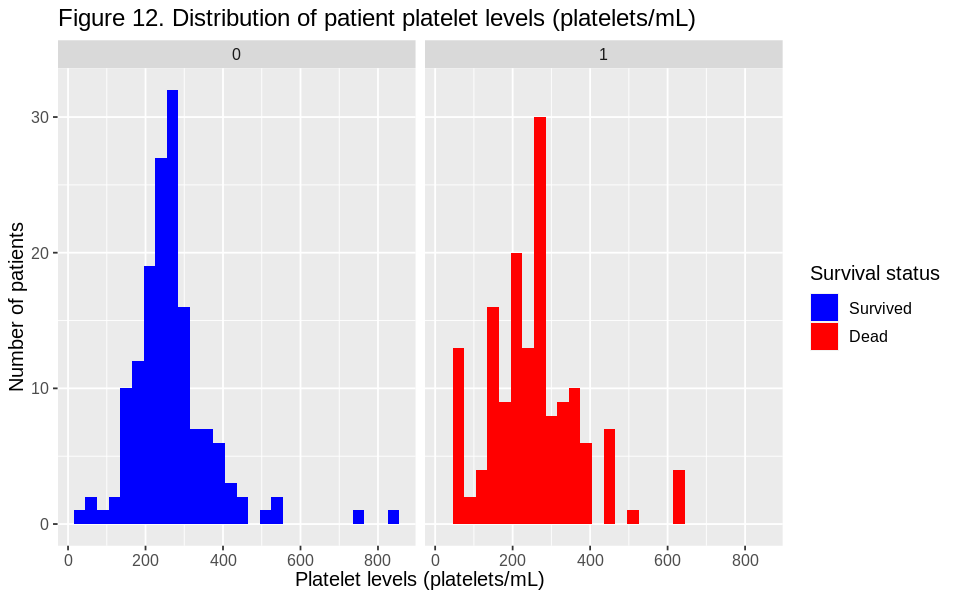

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



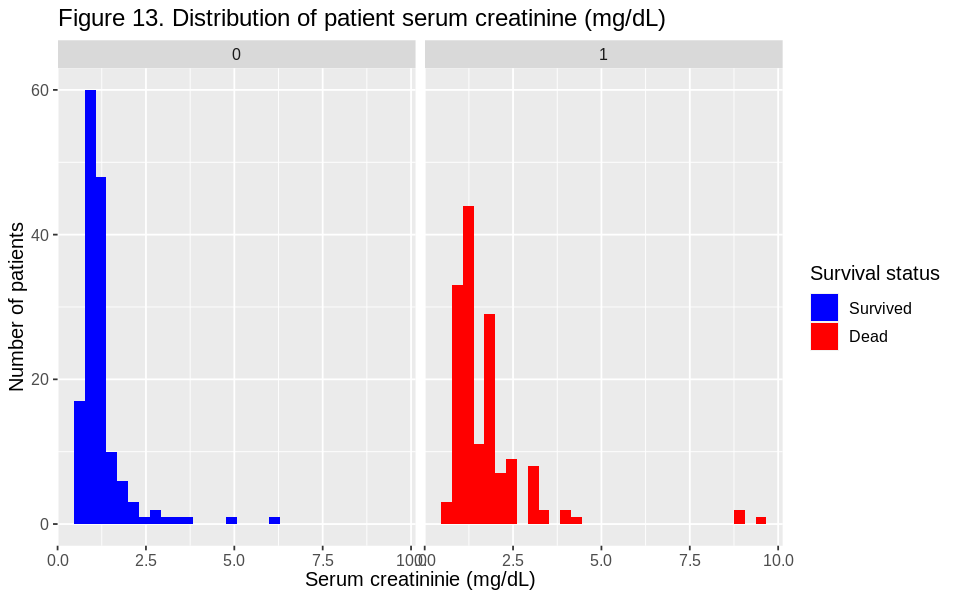

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



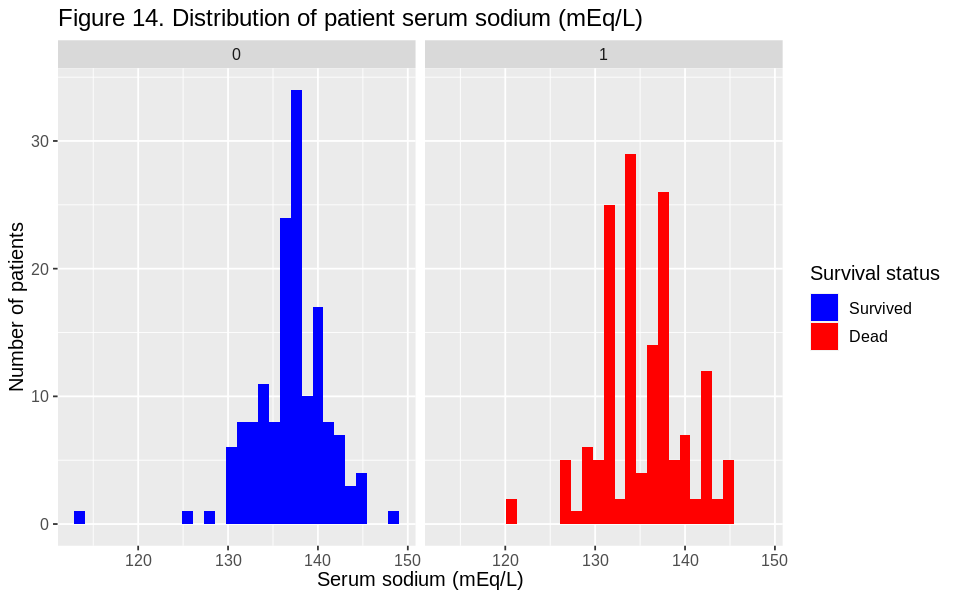

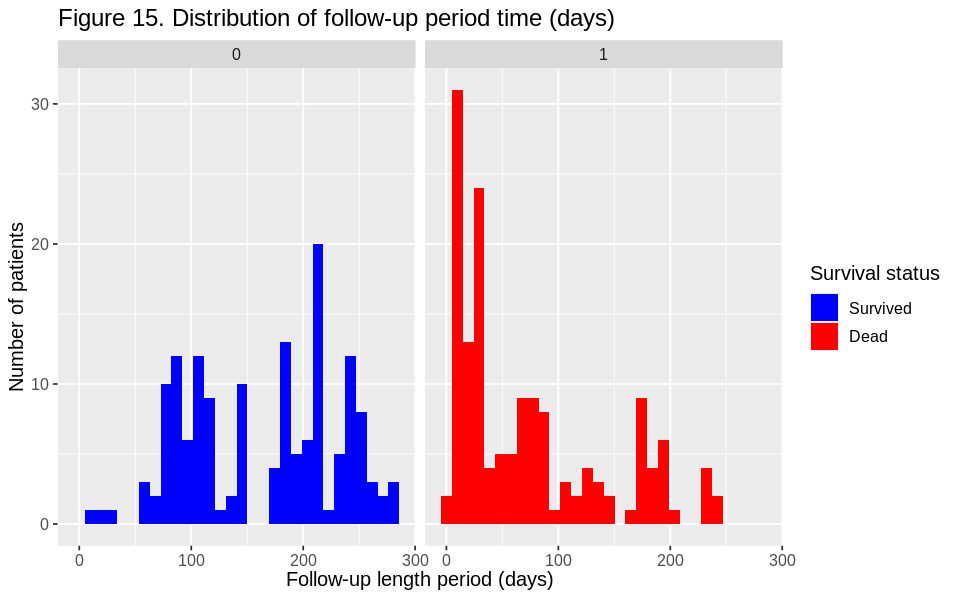

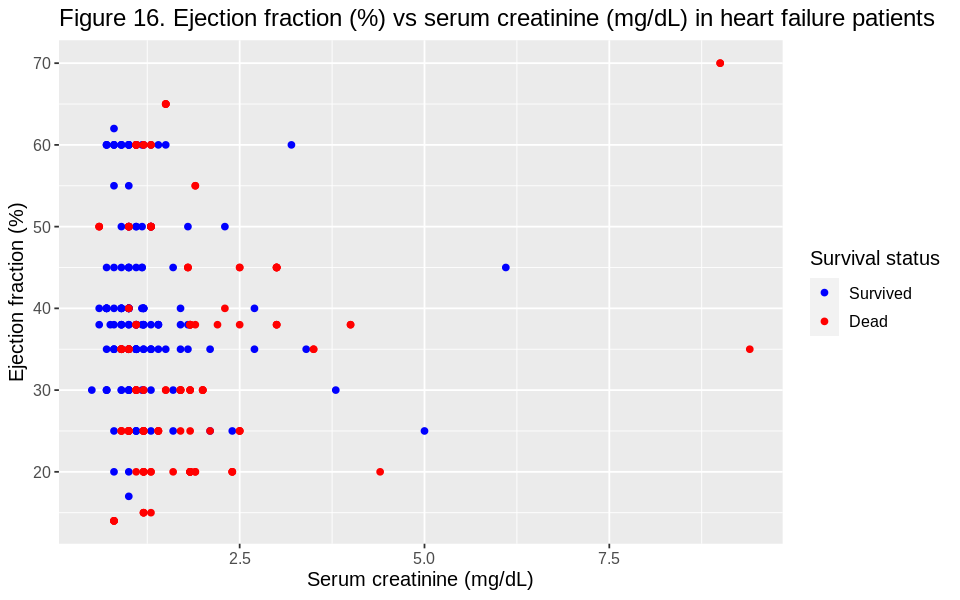

In [74]:
# Plots
options(repr.plot.height = 5, repr.plot.width = 8)

plot9 <- balanced_data |>
    ggplot(aes(x = creatinine_phosphokinase, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 100) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Blood serum creatinine level (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 9. Distribution of patient creatinine phosphokinase levels") + 
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot9

plot10 <- balanced_data |>
    ggplot(aes(x = ejection_fraction, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Ejection fraction (%)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 10. Distribution of patient blood ejection fraction (%)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot10

plot11 <- balanced_data |>
    ggplot(aes(x = age, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Age (years)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 11. Distribution of patient age (years)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot11

plot12 <- balanced_data |>
    ggplot(aes(x = platelets_num_per_mL, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 30) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Platelet levels (platelets/mL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 12. Distribution of patient platelet levels (platelets/mL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot12

plot13 <- balanced_data |>
    ggplot(aes(x = serum_creatinine, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum creatininie (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 13. Distribution of patient serum creatinine (mg/dL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot13

plot14 <- balanced_data |>
    ggplot(aes(x = serum_sodium, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum sodium (mEq/L)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 14. Distribution of patient serum sodium (mEq/L)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot14

plot15 <- balanced_data |>
    ggplot(aes(x = time, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Follow-up length period (days)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 15. Distribution of follow-up period time (days)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot15

plot16 <- balanced_data |>
    ggplot(aes(x = serum_creatinine, y = ejection_fraction, color = DEATH_EVENT)) +
    geom_point() +
    labs(x = "Serum creatinine (mg/dL)",
         y = "Ejection fraction (%)",
         color = "Survival status",
         title = "Figure 16. Ejection fraction (%) vs serum creatinine (mg/dL) in heart failure patients") +
    scale_color_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot16

#### Forward Variable Selection ####

In [78]:
# code is made based on references to Textbook section 6.8
# set seed for reproducible results
set.seed(2130)

# original order
wotime_train_ver_1 <- balanced_data |>
    select(age, anaemia, creatinine_phosphokinase, diabetes, ejection_fraction, high_blood_pressure, 
           platelets_num_per_mL, serum_creatinine, serum_sodium, sex, smoking, DEATH_EVENT)


# turn this into a function
do_forward_selection <- function(data_train) {
    
    accuracies <- tibble(size = integer(),
                         model_formula = character(),
                         accuracy = numeric())

    knn_spec <- nearest_neighbor(weight_func = "rectangular",
                                 neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")

    hf_vfold <- vfold_cv(data_train, v = 5, strata = DEATH_EVENT)

    names <- colnames(data_train |>
                      select(-DEATH_EVENT))

    example <- paste("DEATH_EVENT", "~", paste(names, collapse="+"))

    n_total <- length(names)

    selected <- c()

    for (i in 1:n_total) {
    
        accs <- list()
        models <- list()
    
        for (j in 1:length(names)) {
        
            preds_new <- c(selected, names[[j]])
            model_formula <- paste("DEATH_EVENT", "~", paste(preds_new, collapse = "+"))
    
            hf_recipe <- recipe(as.formula(model_formula),
                                data = data_train) |>
                         step_scale(all_numeric_predictors()) |> # only scale numeric variables
                         step_center(all_numeric_predictors())
        
            acc <- workflow() |>
                   add_recipe(hf_recipe) |>
                   add_model(knn_spec) |>
                   tune_grid(resamples = hf_vfold, grid = 10) |>
                   collect_metrics() |>
                   filter(.metric == "accuracy") |>
                   summarize(max_mean_accuracy = max(mean))
        
            acc <- acc$max_mean_accuracy |> unlist()
        
            accs[[j]] <- acc
            models[[j]] <- model_formula
    
        }
    
        jstar <- which.max(unlist(accs))
        accuracies <- accuracies |>
                      add_row(size = i,
                      model_formula = models[[jstar]],
                      accuracy = accs[[jstar]])
    
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
    }
        accuracies
}

In [18]:
set.seed(2130)
accuracies_ver_1 <- do_forward_selection(wotime_train_ver_1)

##### Table 5. Forward selection results

In [76]:
options(repr.matrix.max.rows = 13)
colnames(accuracies_ver_1) <- c("Model size", "Model formula", "Estimated accuracy")
accuracies_ver_1

Model size,Model formula,Estimated accuracy
<int>,<chr>,<dbl>
1,DEATH_EVENT ~ creatinine_phosphokinase,0.7392473
2,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction,0.8184946
3,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age,0.8487097
4,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes,0.8749462
5,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.8781720
6,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL,0.8686022
7,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex,0.8619355
8,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex+high_blood_pressure,0.8684946
9,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine+platelets_num_per_mL+sex+high_blood_pressure+anaemia,0.8686022


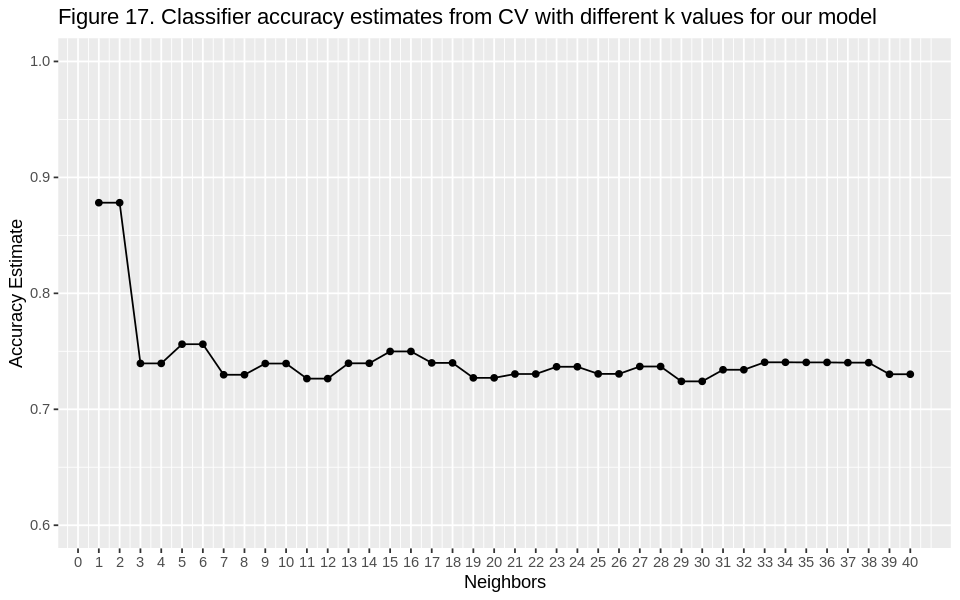

In [42]:
# Find the best k value for our model
set.seed(2130)

gridvals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_k_tuning <- recipe(DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine, data = balanced_data)

#2. Perform 5-fold CV on the training set
knn_vfold_k_tuning <- vfold_cv(balanced_data, v = 5, strata = DEATH_EVENT)

#3. Create the specs with tune() for number of neighbors
knn_k_tuning <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_k_tuning_results <- workflow() |>
    add_recipe(knn_recipe_k_tuning) |>
    add_model(knn_k_tuning) |>
    tune_grid(resamples = knn_vfold_k_tuning, grid = gridvals) |>
    collect_metrics()
                 
accuracies_k_tuning <- knn_k_tuning_results |> 
       filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies_k_tuning, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Figure 17. Classifier accuracy estimates from CV with different k values for our model") +
       scale_x_continuous(breaks = seq(0, 40, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.6, 1.0)) # adjusting the y-axis

cross_val_plot

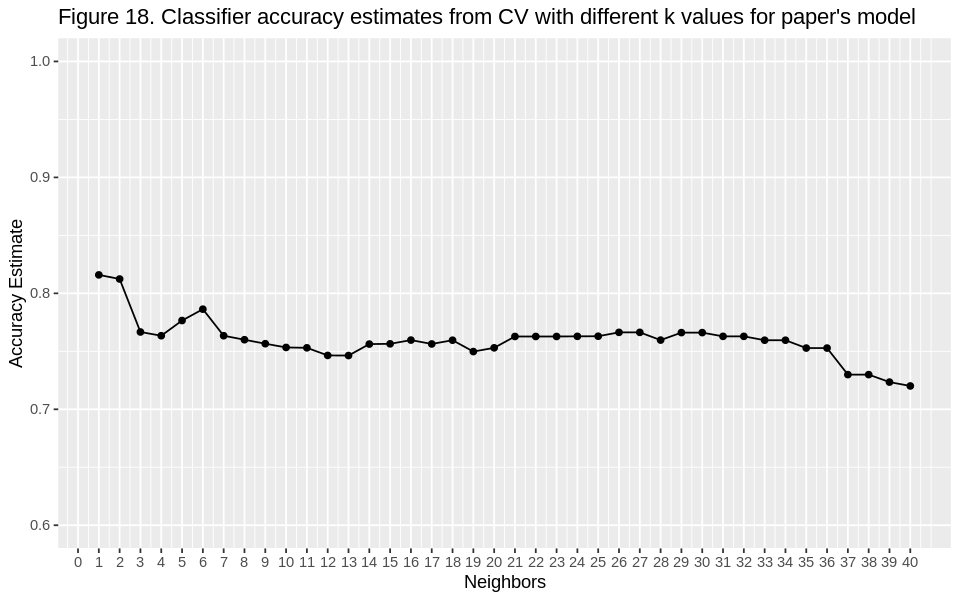

In [43]:
# Find the best k value for the paper's model
set.seed(2130)

gridvals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_k_tuning_paper <- recipe(DEATH_EVENT ~ ejection_fraction+serum_creatinine, data = balanced_data)

#2. Perform 5-fold CV on the training set
knn_vfold_k_tuning_paper <- vfold_cv(balanced_data, v = 5, strata = DEATH_EVENT)

#3. Create the specs with tune() for number of neighbors
knn_k_tuning_paper <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_k_tuning_results_paper <- workflow() |>
    add_recipe(knn_recipe_k_tuning_paper) |>
    add_model(knn_k_tuning_paper) |>
    tune_grid(resamples = knn_vfold_k_tuning_paper, grid = gridvals) |>
    collect_metrics()
                 
accuracies_k_tuning_paper <- knn_k_tuning_results_paper |> 
       filter(.metric == "accuracy")

cross_val_plot_paper <- ggplot(accuracies_k_tuning_paper, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Figure 18. Classifier accuracy estimates from CV with different k values for paper's model") +
       scale_x_continuous(breaks = seq(0, 40, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.6, 1.0)) # adjusting the y-axis

cross_val_plot_paper   

In [44]:
# Find the best model and test it against the testing set, version 1, using K = 2
set.seed(2130)

best_k_2 <- 2

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_best <- recipe(DEATH_EVENT ~  creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine, data = balanced_data)

knn_spec_best_k_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_2) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_k_2 <- workflow() |>
    add_recipe(knn_recipe_best) |>
    add_model(knn_spec_best_k_2) |>
    fit(data = balanced_data)

                 
hf_predictions_k_2 <- predict(knn_best_fit_k_2, testing_data) |>
    bind_cols(testing_data)

hf_metrics_k_2 <- hf_predictions_k_2 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_k_2 <- hf_predictions_k_2 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [45]:
# Find the best model and test it against the testing set, version 2, using K = 5
set.seed(2130)

best_k_5 <- 5

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_best <- recipe(DEATH_EVENT ~  creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine, data = balanced_data)

knn_spec_best_k_5 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_5) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_k_5 <- workflow() |>
    add_recipe(knn_recipe_best) |>
    add_model(knn_spec_best_k_5) |>
    fit(data = balanced_data)

                 
hf_predictions_k_5 <- predict(knn_best_fit_k_5, testing_data) |>
    bind_cols(testing_data)

hf_metrics_k_5 <- hf_predictions_k_5 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_k_5 <- hf_predictions_k_5 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [46]:
# Find the best model and test it against the testing set, version 3, using K = 6
set.seed(2130)

best_k_6 <- 6

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_best <- recipe(DEATH_EVENT ~  creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine, data = balanced_data)

knn_spec_best_k_6 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_6) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_k_6 <- workflow() |>
    add_recipe(knn_recipe_best) |>
    add_model(knn_spec_best_k_6) |>
    fit(data = balanced_data)

                 
hf_predictions_k_6 <- predict(knn_best_fit_k_6, testing_data) |>
    bind_cols(testing_data)

hf_metrics_k_6 <- hf_predictions_k_6 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_k_6 <- hf_predictions_k_6 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [47]:
# Find the best model and test it against the testing set, version 4, using K = 15
set.seed(2130)

best_k_15 <- 15

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_best <- recipe(DEATH_EVENT ~  creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine, data = balanced_data)

knn_spec_best_k_15 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_15) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_k_15 <- workflow() |>
    add_recipe(knn_recipe_best) |>
    add_model(knn_spec_best_k_15) |>
    fit(data = balanced_data)

                 
hf_predictions_k_15 <- predict(knn_best_fit_k_15, testing_data) |>
    bind_cols(testing_data)

hf_metrics_k_15 <- hf_predictions_k_15 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_k_15 <- hf_predictions_k_15 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [48]:
# Find the best model and test it against the testing set, version 5, using K = 16
set.seed(2130)

best_k_16 <- 16

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_best <- recipe(DEATH_EVENT ~  creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine, data = balanced_data)

knn_spec_best_k_16 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_16) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_k_16 <- workflow() |>
    add_recipe(knn_recipe_best) |>
    add_model(knn_spec_best_k_16) |>
    fit(data = balanced_data)

                 
hf_predictions_k_16 <- predict(knn_best_fit_k_16, testing_data) |>
    bind_cols(testing_data)

hf_metrics_k_16 <- hf_predictions_k_16 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_k_16 <- hf_predictions_k_16 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [49]:
# Find the best model and test it against the testing set, version 6, using K = 23
set.seed(2130)

best_k_23 <- 23

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_best <- recipe(DEATH_EVENT ~  creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine, data = balanced_data)

knn_spec_best_k_23 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_23) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_k_23 <- workflow() |>
    add_recipe(knn_recipe_best) |>
    add_model(knn_spec_best_k_23) |>
    fit(data = balanced_data)

                 
hf_predictions_k_23 <- predict(knn_best_fit_k_23, testing_data) |>
    bind_cols(testing_data)

hf_metrics_k_23 <- hf_predictions_k_23 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_k_23 <- hf_predictions_k_23 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [50]:
# Find the best model and test it against the testing set, version 7, using K = 27
set.seed(2130)

best_k_27 <- 27

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_best <- recipe(DEATH_EVENT ~  creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine, data = balanced_data)

knn_spec_best_k_27 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_27) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_k_27 <- workflow() |>
    add_recipe(knn_recipe_best) |>
    add_model(knn_spec_best_k_27) |>
    fit(data = balanced_data)

                 
hf_predictions_k_27 <- predict(knn_best_fit_k_27, testing_data) |>
    bind_cols(testing_data)

hf_metrics_k_27 <- hf_predictions_k_27 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_k_27 <- hf_predictions_k_27 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [51]:
# Find the best model based on the paper and test it against the testing set, version 1, using K = 2
set.seed(2130)

best_k_paper_2 <- 2

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_paper_best <- recipe(DEATH_EVENT ~ ejection_fraction + serum_creatinine, data = balanced_data)

knn_spec_paper_best_k_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_paper_2) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_paper_k_2 <- workflow() |>
    add_recipe(knn_recipe_paper_best) |>
    add_model(knn_spec_paper_best_k_2) |>
    fit(data = balanced_data)

                 
hf_predictions_paper_k_2 <- predict(knn_best_fit_paper_k_2, testing_data) |>
    bind_cols(testing_data)

hf_metrics_paper_k_2 <- hf_predictions_paper_k_2 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_paper_k_2 <- hf_predictions_paper_k_2 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [52]:
# Find the best model based on the paper and test it against the testing set, version 2, using K = 6
set.seed(2130)

best_k_paper_6 <- 6

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_paper_best <- recipe(DEATH_EVENT ~ ejection_fraction + serum_creatinine, data = balanced_data)

knn_spec_paper_best_k_6 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_paper_6) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_paper_k_6 <- workflow() |>
    add_recipe(knn_recipe_paper_best) |>
    add_model(knn_spec_paper_best_k_6) |>
    fit(data = balanced_data)

                 
hf_predictions_paper_k_6 <- predict(knn_best_fit_paper_k_6, testing_data) |>
    bind_cols(testing_data)

hf_metrics_paper_k_6 <- hf_predictions_paper_k_6 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_paper_k_6 <- hf_predictions_paper_k_6 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [53]:
# Find the best model based on the paper and test it against the testing set, version 3, using K = 16
set.seed(2130)

best_k_paper_16 <- 16

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_paper_best <- recipe(DEATH_EVENT ~ ejection_fraction + serum_creatinine, data = balanced_data)

knn_spec_paper_best_k_16 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_paper_16) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_paper_k_16 <- workflow() |>
    add_recipe(knn_recipe_paper_best) |>
    add_model(knn_spec_paper_best_k_16) |>
    fit(data = balanced_data)

                 
hf_predictions_paper_k_16 <- predict(knn_best_fit_paper_k_16, testing_data) |>
    bind_cols(testing_data)

hf_metrics_paper_k_16 <- hf_predictions_paper_k_16 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_paper_k_16 <- hf_predictions_paper_k_16 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [54]:
# Find the best model based on the paper and test it against the testing set, version 4, using K = 23
set.seed(2130)

best_k_paper_23 <- 23

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_paper_best <- recipe(DEATH_EVENT ~ ejection_fraction + serum_creatinine, data = balanced_data)

knn_spec_paper_best_k_23 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_paper_23) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_paper_k_23 <- workflow() |>
    add_recipe(knn_recipe_paper_best) |>
    add_model(knn_spec_paper_best_k_23) |>
    fit(data = balanced_data)

                 
hf_predictions_paper_k_23 <- predict(knn_best_fit_paper_k_23, testing_data) |>
    bind_cols(testing_data)

hf_metrics_paper_k_23 <- hf_predictions_paper_k_23 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_paper_k_23 <- hf_predictions_paper_k_23 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [55]:
# Find the best model based on the paper and test it against the testing set, version 5, using K = 27
set.seed(2130)

best_k_paper_27 <- 27

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_paper_best <- recipe(DEATH_EVENT ~ ejection_fraction + serum_creatinine, data = balanced_data)

knn_spec_paper_best_k_27 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_paper_27) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_paper_k_27 <- workflow() |>
    add_recipe(knn_recipe_paper_best) |>
    add_model(knn_spec_paper_best_k_27) |>
    fit(data = balanced_data)

                 
hf_predictions_paper_k_27 <- predict(knn_best_fit_paper_k_27, testing_data) |>
    bind_cols(testing_data)

hf_metrics_paper_k_27 <- hf_predictions_paper_k_27 |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_paper_k_27 <- hf_predictions_paper_k_27 |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [57]:
# Compare our model and the paper model
models <- c("Ours", "Ours", "Ours", "Ours", "Ours", "Ours", "Ours", 
            "Paper's", "Paper's", "Paper's", "Paper's", "Paper's")
k_vals <- c(2, 5, 6, 15, 16, 23, 27, 
            2, 6, 16, 23, 27)
model_formula <- c("DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine",
                   "DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine",
                   "DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine",
                   "DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine",
                   "DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine",
                   "DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine",
                   "DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine",
                   "DEATH_EVENT ~ ejection_fraction + serum_creatinine", 
                   "DEATH_EVENT ~ ejection_fraction + serum_creatinine", 
                   "DEATH_EVENT ~ ejection_fraction + serum_creatinine", 
                   "DEATH_EVENT ~ ejection_fraction + serum_creatinine", 
                   "DEATH_EVENT ~ ejection_fraction + serum_creatinine")

pred_accu_ours_k_2 <- hf_metrics_k_2 |>
    select(.estimate) |>
    pull()

pred_accu_ours_k_5 <- hf_metrics_k_5 |>
    select(.estimate) |>
    pull()

pred_accu_ours_k_6 <- hf_metrics_k_6 |>
    select(.estimate) |>
    pull()

pred_accu_ours_k_15 <- hf_metrics_k_15 |>
    select(.estimate) |>
    pull()

pred_accu_ours_k_16 <- hf_metrics_k_16 |>
    select(.estimate) |>
    pull()

pred_accu_ours_k_23 <- hf_metrics_k_23 |>
    select(.estimate) |>
    pull()

pred_accu_ours_k_27 <- hf_metrics_k_27 |>
    select(.estimate) |>
    pull()

pred_accu_paper_k_2 <- hf_metrics_paper_k_2 |>
    select(.estimate) |>
    pull()

pred_accu_paper_k_6 <- hf_metrics_paper_k_6 |>
    select(.estimate) |>
    pull()

pred_accu_paper_k_16 <- hf_metrics_paper_k_16 |>
    select(.estimate) |>
    pull()

pred_accu_paper_k_23 <- hf_metrics_paper_k_23 |>
    select(.estimate) |>
    pull()

pred_accu_paper_k_27 <- hf_metrics_paper_k_27 |>
    select(.estimate) |>
    pull()

prediction_accuracy <- c(pred_accu_ours_k_2, pred_accu_ours_k_5, pred_accu_ours_k_6, 
                         pred_accu_ours_k_15, pred_accu_ours_k_16, pred_accu_ours_k_23, 
                         pred_accu_ours_k_27, pred_accu_paper_k_2, pred_accu_paper_k_6, 
                         pred_accu_paper_k_16, pred_accu_paper_k_23, pred_accu_paper_k_27)

prediction_summary <- tibble(models, k_vals, model_formula, prediction_accuracy)
colnames(prediction_summary) <- c("Model", "K values", "Model Formula", "Prediction accuracy on testing data")

In [58]:
options(repr.matrix.max.rows = 12)
prediction_summary

Model,K values,Model Formula,Prediction accuracy on testing data
<chr>,<dbl>,<chr>,<dbl>
Ours,2,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.6800000
Ours,5,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.7066667
Ours,6,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.7066667
Ours,15,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.8133333
Ours,16,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.8133333
Ours,23,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.7733333
Ours,27,DEATH_EVENT ~ creatinine_phosphokinase+ejection_fraction+age+diabetes+serum_creatinine,0.7600000
Paper's,2,DEATH_EVENT ~ ejection_fraction + serum_creatinine,0.7466667
Paper's,6,DEATH_EVENT ~ ejection_fraction + serum_creatinine,0.7200000


In [59]:
# Our model's confusion matrix when K = 15
hf_conf_mat_k_15

          Truth
Prediction  0  1
         0 43  6
         1  8 18

In [60]:
# Paper model's confusion matrix when K = 16
hf_conf_mat_paper_k_16

          Truth
Prediction  0  1
         0 41  7
         1 10 17

## Discussion

#### Summary of results

Our data analysis showed that the model with 5 variables (creatinine phosphokinase, ejection fraction, diabetes, age and serum creatinine) was the best candidate for making the best predictions of whether a heart failure patient would survive after some finite period of time with an estimated accuracy of 87.82% (based on a 5-fold cross-validation). 

After trying 40 different K values for the model with 5-fold cross-validation, the highest estimated prediction accuracy was when K = 2, however, when testing the model with the testing set, the highest prediction accuracy was achieved when K = 15 or 16. We ended up choosing K = 15 to be the best K value because using fewer neighbors to make a prediction with the same-quality would be better. 

Meanwhile, we found something similar for the 2-variable (ejection fraction and serum creatinine) model created based on Chicco and Jurman’s findings, that the highest estimated prediction accuracy was when K = 2 based on a 5-fold cross-validation. But in reality, the best version of that model was when K = 16 with a prediction accuracy of 77.33%. The same logic applied here that even though K = 23 and 27 both gave the same prediction accuracies, it would be better to use fewer neighbors based on principle of parsimony.

Finally, the confusion matrices showed our best model made fewer incorrect predictions for both survived (8 was incorrectly predicted to die) and dead (6 was incorrectly predicted to survive) patients whereas the best model created based on past findings incorrect predicted 10 survived patients being dead and 7 dead patients being alive, suggesting that our model was more suitable for a classification model.

To summarize, in order to predict whether a heart failure patient would survive after some finite period of time, a classification model using the variables creatinine phosphokinase, ejection fraction, diabetes, age, and serum creatinine, and a K value of 15 would be optimal.

#### Whether this is what we expected to find

Among all the model formulas forward selection gave us, creatinine phosphokinase + ejection fraction + diabetes + age + serum creatinine had the highest accuracy at 87.8%. Before we ran forward selection, we expected the outcome to be serum creatinine, ejection fraction (Table 1, Fig. 1~8, Chicco & Jurman, 2020), and some categorical variables. Our result was almost the same as our expected outcome, except for creatinine phosphokinase and diabetes.

We could find the reason forward selection chose ejection fraction, age, and serum creatinine as useful predictors from the histograms of our training set. In Figure 10, half of the survived patients had an ejection fraction above 40%; however, the ejection fraction for most of those who died were below 40%. There is a higher possibility for heart failure patients to die if their ejection fraction is low. For age, Figure 11 showed that the distribution of the dead group was left-skewed while that of the survived group was right-skewed. It implied that older people are more likely to die from heart failure. Additionally, the serum creatinine level of survived patients was centred at around 1.5 mg/dL, while that of dead patients was more spread out with a higher mean value. Higher serum creatinine leads to higher mortality rate.

However, from the exploratory data analysis of our training set, it was difficult to tell why creatinine phosphokinase and diabetes contributed to higher accuracy of the classification model. From the distribution of creatinine phosphokinase for our training data, there was almost no difference between the dead and surviving groups. A research paper suggests that low level of creatinine phosphokinase leads to heart failure, but “severity is dependent on genetic background, gender and age”, which means creatinine phosphokinase level is not directly related to mortality of heart failure (Lygate, 2012). Moreover, Table 4 showed that in our training set, there was 53.39% of diabetic patients and 47.85% of non-diabetic patients survived. According to a research paper on the impact of diabetes mellitus on mortality in patients with acute heart failure, “diabetes mellitus is associated with a higher risk of overall mortality in acute heart failure” (Kong, 2020). Our training data contradicted the result of this research paper, but forward selection still picked diabetes as a useful predictor.

#### What impact could such findings have?
The model could identify potential factors that correlate with heart failure mortality. From that, we could advocate for better living habits if lifestyle-related factors such as smoking is a major predictor for death of heart failure patients. In the case of biological factors such as serum creatinine levels being correlated with heart failure mortality, researchers could look into potential drug treatments that regulate their levels in patients’ bodies to prolong their lifespans. 

A relevant research of “Ways to Maximize Your Lifespan With Heart Failure”, which written by Charlotte Huff indicates that: the doctor will check how well the area of your heart called the left ventricle is pumping blood. An echocardiogram is a frequently used test. It scans the heart and takes measurements to find out what percentage of blood is pumped with each heartbeat. For example, an ejection fraction of 55% means that 55% of the blood is expelled with each hard blow. A normal result is usually between 50% and 70%, according to the American Heart Association. By doing so allows many patients to know their physical condition in advance, and they can carry out some medical measures according to the condition of their own heart.

On the other hand, people should have good living habits: a relevant research showed that the longer the duration of hypertension, the higher the age, the higher the incidence of heart failure, long-term control of hypertension has been shown to reduce the risk of heart failure.(YoungKimMDa, J. (2015, September 8).And in this research, researchers also mentioned that smoking and diabetes are also the main factors leading to high blood pressure. Therefore, patients with heart failure should smoke less and have a more regular work and rest habit. For patients with congenital hypertension, they should also eat less greasy food or food with high sugar content in their diet.

#### What Future Questions Could This Leads To?

Based on some health information of a patient including creatinine phosphokinase, ejection, fraction, diabetes, age, serum creatinine). The accuracy of our model using the predictors listed  above that are selected by applying forward selection is 87.8%. A future question we can ask could be: Is best subset selection applicable and would we get a better accuracy by using the predictors selected by using best subset selection?  If the best subset selection is applicable and would get a better accuracy out of it, are we able to find the top three health factors that are most important in terms of survival of a heart failure patient?

Secondly, The model for this project is merely predicting whether a heart failure patient will die or not based on some health information and the time factor is ignored for simplification. However, sometimes it is a better idea to tell the patients their chance of survival rather than a yes or no answer.  For future questions, are we able to build a more impactful model that can predict the patient’s probability of survival within some specific amount of time given their current health information?

## References:

1. Ahmad, T., Munir, A., Bhatti, S. H., Aftab, M., & Raza, M. A. (2017). Survival analysis of heart failure patients: A case study. *PloS One, 12*(7), e0181001-e0181001. https://doi.org/10.1371/journal.pone.0181001

2. Chairat, K., Rattanavipanon, W., Tanyasaensook, K., Chindavijak, B., Chulavatnatol, S., & Nathisuwan, S. (2020). Relationship of anemia and clinical outcome in heart failure patients with preserved versus reduced ejection fraction in a rural area of Thailand. *International Journal of Cardiology. Heart & Vasculature*, 30, 100597-100597. https://doi.org/10.1016/j.ijcha.2020.100597.

3. Chicco, D., & Jurman, G. (2020). Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. *BMC Medical Informatics and Decision Making, 20*(1), 16-16. https://doi.org/10.1186/s12911-020-1023-5

4. Ding, N., Shah, A. M., Blaha, M. J., Chang, P. P., Rosamond, W. D., & Matsushita, K. (2022). Cigarette smoking, cessation, and risk of heart failure with preserved and reduced ejection fraction. *Journal of the American College of Cardiology, 79*(23), 2298-2305. https://doi.org/10.1016/j.jacc.2022.03.377

5. Inamdar, A. A., & Inamdar, A. C. (2016). Heart Failure: Diagnosis, Management and Utilization. *Journal of Clinical Medicine, 5*(7), 62. https://doi.org/10.3390/jcm5070062

6. Kong, M.G., Jang, S.Y., Jang, J. et al. Impact of diabetes mellitus on mortality in patients with acute heart failure: a prospective cohort study. Cardiovasc Diabetol 19, 49 (2020). https://doi.org/10.1186/s12933-020-01026-3

7. Lygate, C.A., Medway, D.J., Ostrowski, P.J. et al. Chronic creatine kinase deficiency eventually leads to congestive heart failure, but severity is dependent on genetic background, gender and age. Basic Res Cardiol 107, 276 (2012). https://doi.org/10.1007/s00395-012-0276-2

8. Romiti, G. F., Recchia, F., Zito, A., Visioli, G., Basili, S., & Raparelli, V. (2022, April 21). Sex and gender-related issues in heart failure. *Cardiology Clinics, 40*(2), 259-268. https://doi.org/10.1016/j.ccl.2021.12.013

9. WebMD. (n.d.). Heart failure and life expectancy. WebMD. Retrieved December 4, 2022,from https://www.webmd.com/heart-disease/heart-failure/features/heart-failure-life-expectancy
 




10. YoungKimMDa, J. (2015, September 8). Prognostic impact of preexisting hypertension and high systolic blood pressure at admission in patients hospitalized for systolic heart failure. Journal of Cardiology. Retrieved December 4, 2022, from https://www.sciencedirect.com/science/article/pii/S0914508715002439